In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import optuna
import functools

from floOTflix.datasets import toydata_get_dataset
from floOTflix.utils import seed
from floOTflix.plots import plot_heatmap
from floOTflix.models import CLIDIOTModel, CLIDIOTGradientModel, MFModel, DeepMatrixtModel

# Generate dataset

/Users/lucasmrdt/.pyenv/versions/3.10.6/lib/python3.10/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


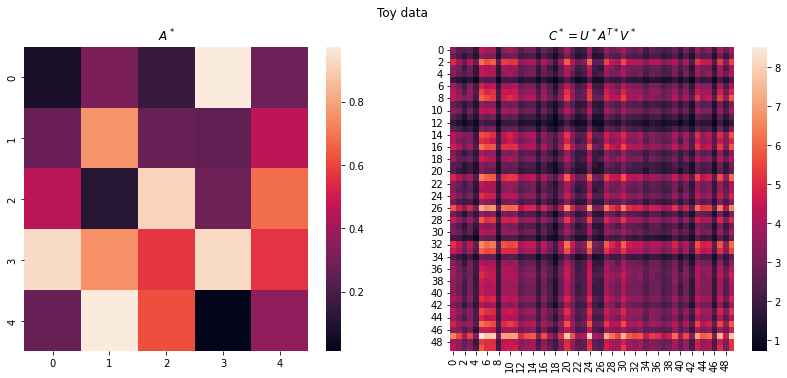

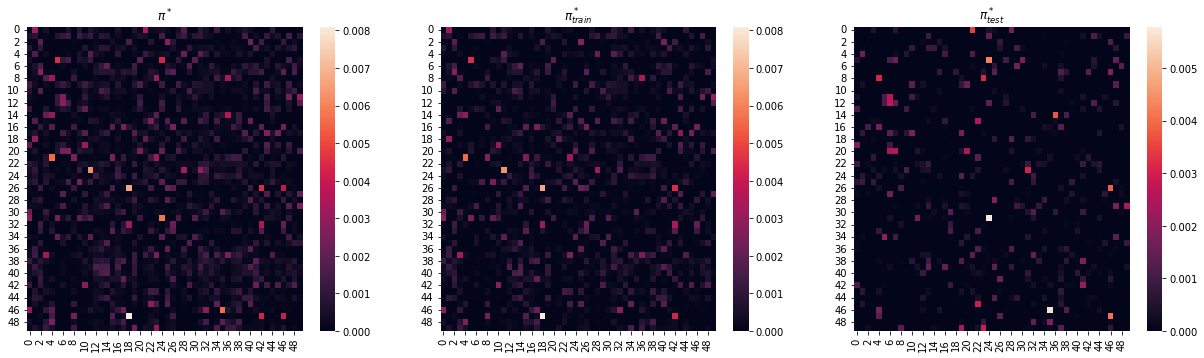

In [5]:
m, n = 50, 50
k = 5

seed(0)

(X_train, y_train), (X_test, y_test), (pi_train, pi_test, C_truth, U_truth, V_truth, A_truth) = toydata_get_dataset(m, n, k)

pi_train = pi_train.nan_to_num()
pi_test = pi_test.nan_to_num()
pi_sample = pi_train + pi_test

X = torch.cat([X_train, X_test], dim=0)
y = torch.cat([y_train, y_test], dim=0)

y_test_normalized = (y_test - y_test.min()) / (y_test.max() - y_test.min())

plot_heatmap(matrices=[A_truth, C_truth], titles=["$A^*$", "$C^* = U^*{A^T}^*V^*$"], title="Toy data")
plot_heatmap(matrices=[pi_sample, pi_train, pi_test], titles=["$\pi^*$", "$\pi^*_{train}$", "$\pi^*_{test}$"])

# Solve using CLIDIOT

In [6]:
m, n, k = *pi_sample.shape, A_truth.shape[0]

U = U_truth
V = V_truth

trial = functools.partial(CLIDIOTModel.optuna_trial, m, n, X, y, X_test, y_test, U, V)
study = optuna.create_study(direction='minimize')
study.optimize(trial, n_trials=100)

[I 2022-10-16 20:12:08,052] A new study created in memory with name: no-name-3223069a-a4e2-4834-a801-e63437322f51


In [12]:
study.best_params

{'eps': 7.117140576005326,
 'max_clidiot_iter': 313,
 'max_prox_iter': 354,
 'prox_lr': 0.022761152209025193,
 'prox_gamma': 7.97926813515542,
 'prox_reg': 0.2444655698983902,
 'c0': '1e-2',
 'ot_lambda': 7.527066574918035}

In [22]:
c0 = torch.ones(m, n)
alpha0 = torch.ones(m)
beta0 = torch.ones(n)

best_params = {'eps': 7.117140576005326,
               'max_clidiot_iter': 313,
               'max_prox_iter': 354,
               'prox_lr': 0.022761152209025193,
               'prox_gamma': 7.97926813515542,
               'prox_reg': 0.2444655698983902,
               'c0': '1e-2',
               'ot_lambda': 7.527066574918035}
best_params = {k: v for k, v in best_params.items() if k not in ('c0', 'alpha0', 'beta0')}

model = CLIDIOTModel(m, n, **best_params, c0=c0,
                     alpha0=alpha0, beta0=beta0, verbose=True)
train_errors, test_errors = model.fit(X_train, y_train, X_test, y_test, U, V)

sns.lineplot(x=np.arange(len(train_errors)),
             y=train_errors, label="Train error")
sns.lineplot(x=np.arange(len(test_errors)), y=test_errors, label="Test error")


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/lucasmrdt/.pyenv/versions/3.10.6/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/23/phdc9zdx6bd4kxsb9bfjxbmc0000gn/T/ipykernel_62207/1441804099.py", line 17, in <cell line: 17>
    train_errors, test_errors = model.fit(X_train, y_train, X_test, y_test, U, V)
  File "/Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/clidiot.py", line 200, in fit
    self.c = self.clidiot(pi_train, prox_fn, logger=logger)
  File "/Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/clidiot.py", line 92, in clidiot
    c = prox_fn(-eps * torch.log(K))
  File "/Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/clidiot.py", line 168, in prox_fn
    A_hat = U_inv @ c @ V_inv.t()
RuntimeError: mat1 and mat2 shapes cannot be multiplied

/Users/lucasmrdt/.pyenv/versions/3.10.6/lib/python3.10/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


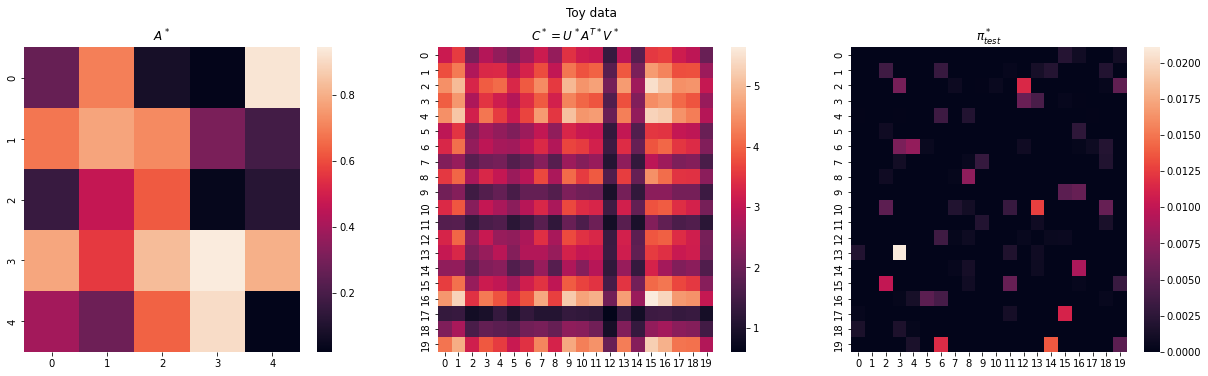

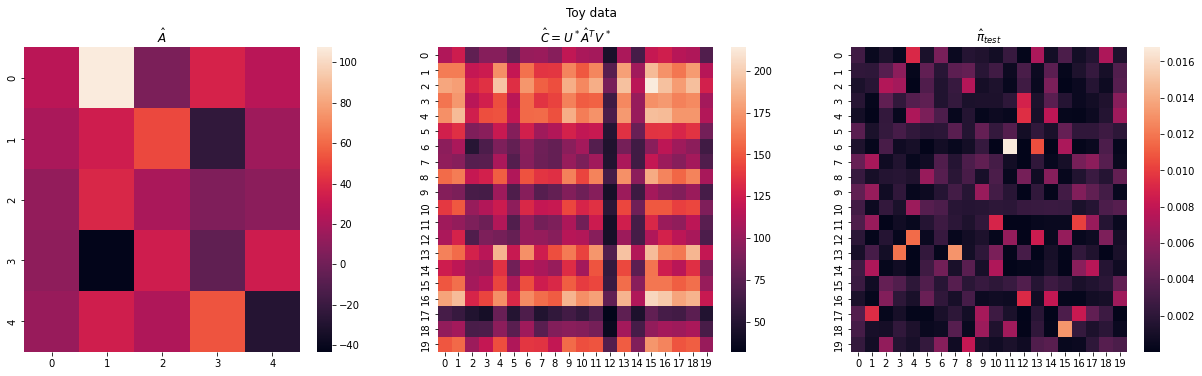

In [9]:
A_hat = model.A
C_hat = U @ A_hat @ V.t()
pi_hat_test = model.ot(c=C_hat)
y_test_pred = model.predict(X_test)

plot_heatmap(matrices=[A_truth, C_truth, pi_test], titles=["$A^*$", "$C^* = U^*{A^T}^*V^*$", "$\pi^*_{test}$"], title="Toy data")
plot_heatmap(matrices=[A_hat, C_hat, pi_hat_test], titles=["$\hat{A}$", "$\hat{C} = U^* \hat{A}^T V^*$", "$\hat{\pi}_{test}$"], title="Toy data")

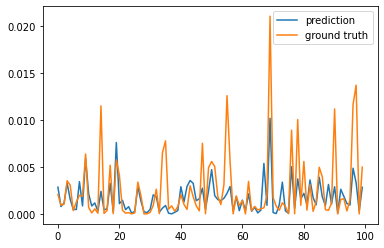

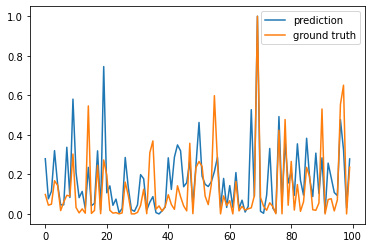

AME: tensor(0.0978)


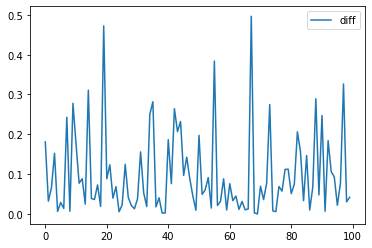

In [20]:
y_test_pred_normalized = (y_test_pred - y_test_pred.min()) / (y_test_pred.max() - y_test_pred.min())
y_test_normalized = (y_test - y_test.min()) / (y_test.max() - y_test.min())

sns.lineplot(x=range(len(X_test)), y=y_test_pred, label="prediction")
sns.lineplot(x=range(len(X_test)), y=y_test, label="ground truth")
plt.show()
sns.lineplot(x=range(len(X_test)), y=y_test_pred_normalized, label="prediction")
sns.lineplot(x=range(len(X_test)), y=y_test_normalized, label="ground truth")
plt.show()
sns.lineplot(x=range(len(X_test)), y=np.abs(y_test_pred_normalized - y_test_normalized), label="diff")
print("AME:", np.abs(y_test_pred_normalized - y_test_normalized).mean())